СРАВНЕНИЕ ВЕБ-СТРАНИЦ

Требуется определить какая из двух страниц с презентацией повышает количество продаж ("A" или "B"). 
Одна из потенциальных эрзац-переменной - время, которое посетители проводят на странице с презентацией. 
Разумно предположить, что презентация, которая задерживает внимание дольше, приведет к большему количеству продаж. 
Следовательно метрикой будет среднее время сеанса.

THE DATA: (36 records)
     Page  Time
0  Page A  0.21
1  Page B  2.53
2  Page A  0.35
3  Page B  0.71
4  Page A  0.67 

BOX PLOTS: The difference between means spent time: 21.4 sec


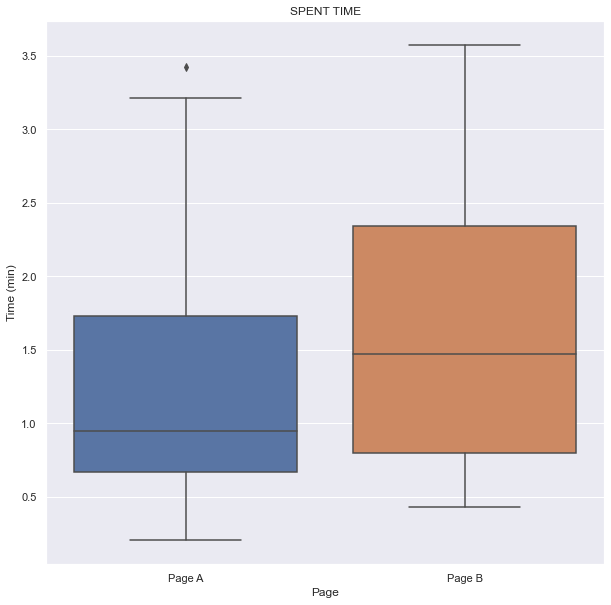

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

df = pd.read_csv('/Users/ivankudravcev/Studying/Data/web_pages_data.csv', sep=',', skiprows=8, header=None)
df.rename(columns={0:'Page', 1:'Time'}, inplace=True)  # rename columns

time = np.array(df['Time']) # value type in column "Time" is string
time_to_float = []

# remove extra characters and cast n to float
for n in time:
    n = n.replace('\\','')
    n = n.replace('}','')
    n = float(n)
    time_to_float.append(n)
  
df['Time'] = time_to_float

# THE DATA
print('THE DATA: (36 records)')
print(df.head(), '\n')

# Separate df -> Page "A" & Page "B"
A = df[df['Page']=='Page A']
B = df[df['Page']=='Page B']

nA = len(A)
nB = len(B)

# Calculate difference between mean visiting time of Page "A" & Page "B"
meanA = np.mean(A['Time'])
meanB = np.mean(B['Time'])
difference = np.absolute((meanA-meanB)*60).round(2)

# Draw Boxplots
print(f'BOX PLOTS: The difference between means spent time: {difference} sec')
plt.figure(figsize=(10, 10))
sns.boxplot(x=df['Page'], y=df['Time'])
plt.ylabel('Time (min)')
plt.title('SPENT TIME')
plt.show()

Из проведенного анализа видно, что среднее время проведенное пользователями на странице "B" больше на 21.4 сек. 
Страницу "А" поситили 21 раз, а страницу "В" - 15 раз. 
Теперь нужно проверить может ли быть полученнная разница пораждена случайностью? 
Один из способов проверить это - перестановочный тест.

RANDOMIZE PERMUTATION TEST:


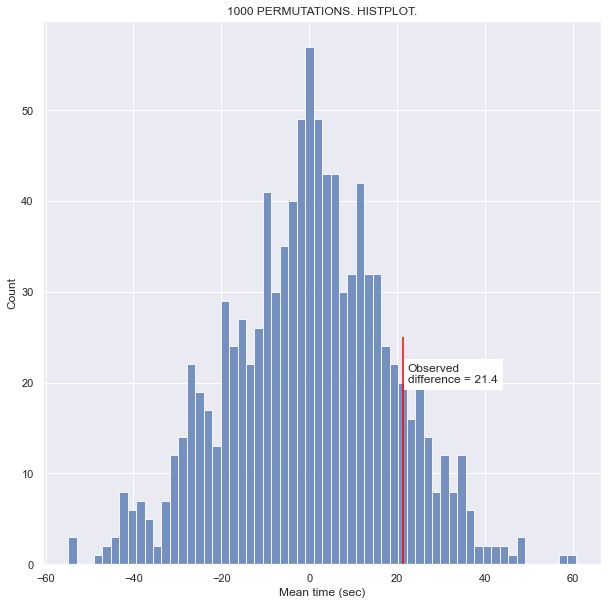

PERMUTATION TEST RESULT:
The Difference (21,4 sec) is deep in the permutation distribution.
Therefore this result due to chance with high degree of probability.
Permutation test p-value = 0.2360


In [20]:
# PERMURARTION TEST
# Generating samples with same length of pages A & B and calculating difference 
# between means of this samples x R times. Samples whithout replace.
R = 1000
permutation_means = []
for i in range(R):
    smplA = df.sample(nA, replace=False)
    indexes = df.index.delete(smplA.index)
    smplB = df.iloc[indexes]
    m1 = float(np.mean(smplA['Time']))
    m2 = float(np.mean(smplB['Time']))
#     permutation_means.append((np.abs(m1-m2)*60).round(2))
    permutation_means.append((m1-m2)*60)

print('RANDOMIZE PERMUTATION TEST:')

# Draw histplot
plt.figure(figsize=(10,10))
plt.vlines(x=difference, ymin=0, ymax=25, colors='Red')
plt.text(difference+1,20, f'Observed\ndifference = {difference}', bbox = {'facecolor':'white'})
sns.histplot(x=permutation_means, bins=60)
plt.xlabel('Mean time (sec)')
plt.title(f'{R} PERMUTATIONS. HISTPLOT.')
plt.show()

# Output
print('PERMUTATION TEST RESULT:')
print('The Difference (21,4 sec) is deep in the permutation distribution.')
print('Therefore this result due to chance with high degree of probability.')

p_val = np.mean([difference < dif for dif in permutation_means])
print(f'Permutation test p-value = {p_val*2:.4f}')

Перестановочный тест показал, что средняя разница случайных перестановок часто 
превышает наблюдаемую разницу. Это происходит в 14.6% случаев. 
Это свидетельствует о том, что наблюдаемая разница между сеансами страниц "А" и "В" находится глубоко 
внутри диапазона случаной вариации и, следовательно, не является статистически значимой.

In [3]:
# T-TEST

from scipy import stats

"""
Get p-value from t-test and compare both p-values

"""

res = stats.ttest_ind(df[df.Page=='Page A'].Time,
                      df[df.Page=='Page B'].Time,
                      equal_var=False)
print(f'"t-test" p-value = {res.pvalue:.4f}')

"t-test" p-value = 0.2815


t-Test:
p-значение t-теста является сопоставимым с p-значением перестановочного теста

Observed difference: 21.40 sec
Views: Page A = 21; Page B = 15


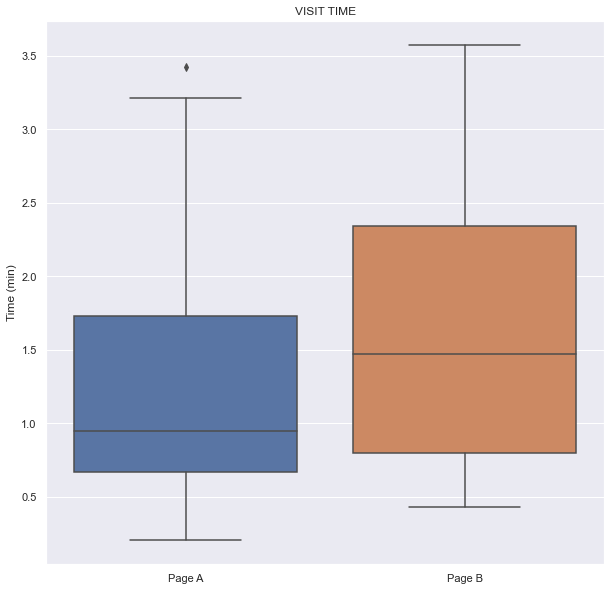

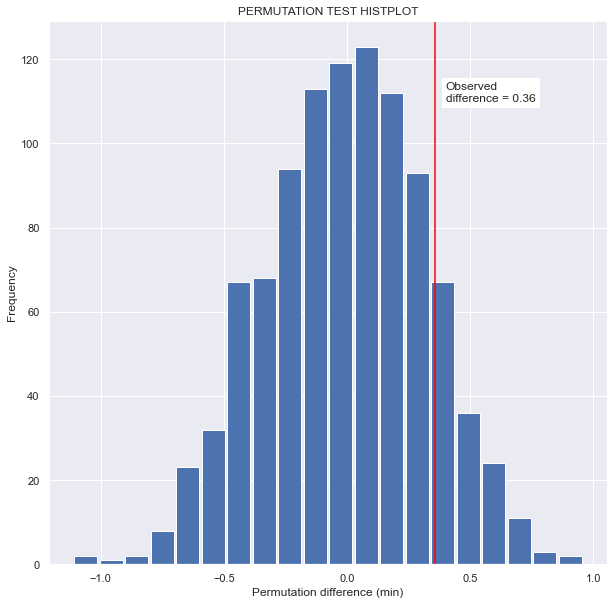

Randomness can generate 26.20% more marginal results than the observed difference (0.36)


In [17]:
# ALTERNATIVE SOLUTION PERMUTATION TEST

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

df = pd.read_csv('/Users/ivankudravcev/Studying/Data/web_page_data.csv', sep=';')
columns = df.columns
columns = columns[2:]
df = df.drop(columns, axis=1)

A = df[df.Page == 'Page A'].Time
B = df[df.Page == 'Page B'].Time

nA = len(A)
nB = len(B)

mean_A = A.mean()
mean_B = B.mean()

obs_dif = abs(mean_A - mean_B)
print(f'Observed difference: {obs_dif*60:.2f} sec')
print(f'Views: Page A = {nA}; Page B = {nB}')

# Draw boxplot
plt.figure(figsize=(10,10))
plt.title('VISIT TIME')
sns.boxplot(x=df['Page'], y=df['Time'])
plt.xlabel('')
plt.ylabel('Time (min)')
plt.show()

def per_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n))-idx_B
    return x.loc[idx_A].mean() - x.loc[idx_B].mean()

R = 1000 # resamples count
permutation_diff = [per_fun(df['Time'], nA, nB) for _ in range(R)]

greater_results = np.mean(permutation_diff>(mean_B-mean_A))*100

# Draw histplot
plt.figure(figsize=(10, 10))
plt.title('PERMUTATION TEST HISTPLOT', )
plt.hist(permutation_diff, bins=20, rwidth=0.9)
plt.axvline(obs_dif, color='red')
plt.text(0.4, 110, f'Observed\ndifference = {obs_dif:.2f}',bbox = {'facecolor':'white'})
plt.xlabel('Permutation difference (min)')
plt.ylabel('Frequency')
plt.show()

print(f'Randomness can generate {greater_results*2:.2f}% more marginal results than the observed difference ({obs_dif:.2f})')